# Mount drive

#1.Import Library




In [ ]:
!pip install varname keras-metrics h5py sastrawi wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 KB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=063aea14fa6a4b95b3ad011302c623dfbe77a49d67feed2bcade3c58b568af2d
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [ ]:
import nltk
import pandas as pd
import re
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt
import keras_metrics as km
import pickle
import keras
from sklearn.model_selection import KFold # import KFold
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Activation, Embedding, LSTM, Bidirectional, Dropout, GRU
from keras import regularizers
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from nltk.tokenize import TweetTokenizer
from collections import defaultdict
from datetime import timedelta
from gensim.models import word2vec
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score, multilabel_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from varname import nameof
from numpy import savetxt
import seaborn as sns
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report

from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import wget

from numpy import asarray
from numpy import savetxt

#2.Load Data

In [ ]:
#simpan path dataset
data_sentimen = pd.read_csv("/content/prabowo new.csv",sep=";")
# path_test_data = "/content/drive/My Drive/Thesis/Tesis/program/data/dataset/new_dataset/test_data.csv"
# test_data = pd.read_csv(path_test_data, sep=";", header=[0], encoding="UTF-8")
data_sentimen.head()

,username,tweet,label
0,melatiseptian11,Jatim Dianggap Battleground Paling Sengit di P...,1
1,GaniSamudera,“Isu bakal majunya pasangan Prabowo/Khofifah y...,1
2,BaraZhafir,"Isu Disandingkan dengan Khofifah di 2024, Elek...",1
3,Taniaanandaa,"""Kalau beliau jadi Presiden inilah yang akan b...",1
4,mhmmdalbarr,Mobil bantuan Prabowo tersebut akan digunakan ...,1


#3.Implementasi Preprocessing

In [ ]:
#menyimpan tweet. (tipe data series pandas)
data_content = data_sentimen['tweet']

##3.1. Casefolding

In [ ]:
# casefolding
data_casefolding = data_content.str.lower()
data_casefolding.head()

0    jatim dianggap battleground paling sengit di p...
1    “isu bakal majunya pasangan prabowo/khofifah y...
2    isu disandingkan dengan khofifah di 2024, elek...
3    "kalau beliau jadi presiden inilah yang akan b...
4    mobil bantuan prabowo tersebut akan digunakan ...
Name: tweet, dtype: object

##3.2. Filtering

In [ ]:
#filtering

#url
filtering_url = [re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", tweet) for tweet in data_casefolding]
#cont
filtering_cont = [re.sub(r'\(cont\)'," ", tweet)for tweet in filtering_url]
#punctuatuion
filtering_punctuation = [re.sub('[!"”#$%&’()*+,-./:;<=>?@[\]^_`{|}~]', ' ', tweet) for tweet in filtering_cont]  #hapus simbol'[!#?,.:";@()-_/\']'
#  hapus #tagger
filtering_tagger = [re.sub(r'#([^\s]+)', '', tweet) for tweet in filtering_punctuation]
#numeric
filtering_numeric = [re.sub(r'\d+', ' ', tweet) for tweet in filtering_tagger]

# # filtering RT , @ dan #
# fungsi_clen_rt = lambda x: re.compile('\#').sub('', re.compile('rt @').sub('@', x, count=1).strip())
# clean = [fungsi_clen_rt for tweet in filtering_numeric]

data_filtering = pd.Series(filtering_numeric)


In [ ]:
data_filtering

0       jatim dianggap battleground paling sengit di p...
1       “isu bakal majunya pasangan prabowo khofifah y...
2       isu disandingkan dengan khofifah di    elektab...
3        kalau beliau jadi presiden inilah yang akan b...
4       mobil bantuan prabowo tersebut akan digunakan ...
                              ...                        
999      mendingprabowo   prabowosubianto   prabowopre...
1000     mendingprabowo   prabowosubianto   prabowopre...
1001    bahkan ada juga  ketua majelis kehormatan part...
1002    prabowo subianto memang masih belum tergoyahka...
1003    jika pilpres dilaksanakan saat ini  prabowo su...
Length: 1004, dtype: object

## 3.3. Tokenisasi

In [ ]:
# #tokenize
tknzr = TweetTokenizer()
data_tokenize = [tknzr.tokenize(tweet) for tweet in data_filtering]

In [ ]:
data_tokenize[:5]

##3.4. Konversi Slangword

In [ ]:
#slang word
path_dataslang = open("/content/kamus kata baku-clear (1).csv")
dataslang = pd.read_csv(path_dataslang, encoding = 'utf-8', header=None, sep=";")

def replaceSlang(word):
  if word in list(dataslang[0]):
    indexslang = list(dataslang[0]).index(word)
    return dataslang[1][indexslang]
  else:
    return word

data_formal = []
for data in data_tokenize:
  data_clean = [replaceSlang(word) for word in data]
  data_formal.append(data_clean)
len_data_formal = len(data_formal)
print(data_formal)
len_data_formal

[['jatim', 'dianggap', 'battleground', 'paling', 'sengit', 'di', 'pilpres', 'bakal', 'dimenangkan', 'prabowo', 'prabowo', 'dekade', 'mendingprabowo', 'pilpres', 'terusmajubersamaprabowo'], ['“', 'isu', 'bakal', 'majunya', 'pasangan', 'prabowo', 'khofifah', 'yang', 'sempat', 'beredar', 'belum', 'lama', 'ini', 'nampaknya', 'cukup', 'mendongkrak', 'elektabilitas', 'prabowo', 'di', 'jawa', 'timur', 'kata', 'peneliti', 'lsn', 'gema', 'nusantara', 'prabowo', 'dekade', 'mendingprabowo', 'pilpres', 'terusmajubersamaprabowo'], ['isu', 'disandingkan', 'dengan', 'khofifah', 'di', 'elektabilitas', 'prabowo', 'naik', 'di', 'jawa', 'timur', 'prabowo', 'dekade', 'mendingprabowo', 'pilpres', 'terusmajubersamaprabowo'], ['kalau', 'beliau', 'jadi', 'presiden', 'inilah', 'yang', 'akan', 'beliau', 'lakukan', 'beliau', 'selalu', 'ingin', 'mengabdi', 'untuk', 'rakyat', 'kata', 'muzani', 'prabowo', 'dekade', 'mendingprabowo', 'pilpres', 'terusmajubersamaprabowo'], ['mobil', 'bantuan', 'prabowo', 'tersebut', 

1004

## 3.5. Stopword

In [ ]:
nltk.download('stopwords')
default_stop_words = nltk.corpus.stopwords.words('indonesian')
stopwords = set(default_stop_words)

def removeStopWords(line, stopwords):
  words = []
  for word in line:  
    word=str(word)
    word = word.strip()
    if word not in stopwords and word != "" and word != "&":
      words.append(word)

  return words
data_notstopword = [removeStopWords(line,stopwords) for line in data_formal]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##3.6. Stemming

In [ ]:
white_list = ["bali"] #ini perlu/tidak perlu diubah karena dianggap sastrawi sebagai imbuhan i

factory = StemmerFactory()
ind_stemmer = factory.create_stemmer()
def stemmer(line):
    temp = list()
    for word in line:
      if(word not in white_list):
        word = ind_stemmer.stem(word)
      if(len(word)>3):
        temp.append(word)
    return temp

reviews = [stemmer (line) for line in data_notstopword]
print(reviews)

[['jatim', 'anggap', 'battleground', 'sengit', 'pilpres', 'menang', 'prabowo', 'prabowo', 'dekade', 'mendingprabowo', 'pilpres', 'terusmajubersamaprabowo'], ['maju', 'pasang', 'prabowo', 'khofifah', 'edar', 'nampaknya', 'dongkrak', 'elektabilitas', 'prabowo', 'jawa', 'timur', 'teliti', 'gema', 'nusantara', 'prabowo', 'dekade', 'mendingprabowo', 'pilpres', 'terusmajubersamaprabowo'], ['sanding', 'khofifah', 'elektabilitas', 'prabowo', 'jawa', 'timur', 'prabowo', 'dekade', 'mendingprabowo', 'pilpres', 'terusmajubersamaprabowo'], ['beliau', 'presiden', 'beliau', 'laku', 'beliau', 'abdi', 'rakyat', 'muzani', 'prabowo', 'dekade', 'mendingprabowo', 'pilpres', 'terusmajubersamaprabowo'], ['mobil', 'bantu', 'prabowo', 'bersih', 'masjid', 'musholla', 'sabang', 'merauke', 'prabowo', 'dekade', 'mendingprabowo', 'pilpres', 'terusmajubersamaprabowo'], ['kasihan', 'remaja', 'masjid', 'usaha', 'jabat', 'tokoh', 'kasih', 'remaja', 'masjid', 'mobil', 'alhamdulillah', 'prabowo', 'bukti', 'ustaz', 'das a

In [ ]:
import pickle

# write list to binary file
def write_list(a_list):
    # store list in binary file so 'wb' mode
    with open('prabowo_data_clean', 'wb') as fp:
        pickle.dump(names, fp)
        print('Done writing list into a binary file')
# list of names
names = reviews
write_list(names)

Done writing list into a binary file


In [ ]:
# Read list to memory
def read_list():
    # for reading also binary mode is important
    with open('prabowo_data_clean', 'rb') as fp:
        n_list = pickle.load(fp)
        return n_list
#Read
reviews = read_list()
print(reviews)

[['jatim', 'anggap', 'battleground', 'sengit', 'pilpres', 'menang', 'prabowo', 'prabowo', 'dekade', 'mendingprabowo', 'pilpres', 'terusmajubersamaprabowo'], ['maju', 'pasang', 'prabowo', 'khofifah', 'edar', 'nampaknya', 'dongkrak', 'elektabilitas', 'prabowo', 'jawa', 'timur', 'teliti', 'gema', 'nusantara', 'prabowo', 'dekade', 'mendingprabowo', 'pilpres', 'terusmajubersamaprabowo'], ['sanding', 'khofifah', 'elektabilitas', 'prabowo', 'jawa', 'timur', 'prabowo', 'dekade', 'mendingprabowo', 'pilpres', 'terusmajubersamaprabowo'], ['beliau', 'presiden', 'beliau', 'laku', 'beliau', 'abdi', 'rakyat', 'muzani', 'prabowo', 'dekade', 'mendingprabowo', 'pilpres', 'terusmajubersamaprabowo'], ['mobil', 'bantu', 'prabowo', 'bersih', 'masjid', 'musholla', 'sabang', 'merauke', 'prabowo', 'dekade', 'mendingprabowo', 'pilpres', 'terusmajubersamaprabowo'], ['kasihan', 'remaja', 'masjid', 'usaha', 'jabat', 'tokoh', 'kasih', 'remaja', 'masjid', 'mobil', 'alhamdulillah', 'prabowo', 'bukti', 'ustaz', 'das a

#4.Konversi Kalimat

In [ ]:
#Pembuatan Kamus kata
t  = Tokenizer()
fit_text = reviews
t.fit_on_texts(fit_text)

#Pembuatan Id masing-masing kata
sequences = t.texts_to_sequences(reviews)

#hapus duplikat kata yang muncul
list_set_sequence = [list(dict.fromkeys(seq)) for seq in sequences]

#mencari max length sequence
def FindMaxLength(lst): 
    maxList = max((x) for x in lst) 
    maxLength = max(len(x) for x in lst ) 
    return maxList, maxLength 
      
# Driver Code 
max_seq, max_length_seq = FindMaxLength(list_set_sequence)
jumlah_index = len(t.word_index) +1

print('jumlah index : ',jumlah_index,'\n')
print('word_index : ',t.word_index,'\n')
print('index kalimat asli     : ', sequences,'\n')
print('kalimat tanpa duplikat : ',list_set_sequence,'\n')
print('panjang max kalimat : ', max_length_seq,'kata','\n')
# print('kalimat terpanjang setelah dihapus duplikat : ', max_seq,'\n')

count_word = [len(i) for i in list_set_sequence]
print('list panjang kalimat : ', count_word)
max_len_word = max(count_word)
print(max_len_word)

jumlah index :  699 

word_index :  {'prabowo': 1, 'pilpres': 2, 'mendingprabowo': 3, 'terusmajubersamaprabowo': 4, 'dekade': 5, 'gerindra': 6, 'indonesia': 7, 'muzani': 8, 'maju': 9, 'partai': 10, 'subianto': 11, 'presiden': 12, 'lato': 13, 'rakyat': 14, 'orang': 15, 'beliau': 16, 'urus': 17, 'bela': 18, 'kader': 19, 'sandiaga': 20, 'dasco': 21, 'temu': 22, 'jawa': 23, 'kampung': 24, 'kuasa': 25, 'gang': 26, 'miskin': 27, 'abdi': 28, 'lemah': 29, 'rizky': 30, 'menang': 31, 'ketua': 32, 'das ad': 33, 'latief': 34, 'masjid': 35, 'bangsa': 36, 'pimpin': 37, 'spanduk': 38, 'main': 39, 'pilih': 40, 'manfaat': 41, 'bantu': 42, 'ustaz': 43, 'menteri': 44, 'negara': 45, 'jabat': 46, 'juang': 47, 'organisasi': 48, 'kaum': 49, 'bukti': 50, 'tani': 51, 'pergok': 52, 'survei': 53, 'ahmad': 54, 'barat': 55, 'timur': 56, 'mobil': 57, 'hasil': 58, 'menhan': 59, 'remaja': 60, 'komitmen': 61, 'hidup': 62, 'anggur': 63, 'pensiun': 64, 'pinggir': 65, 'tukang': 66, 'tunduk': 67, 'patuh': 68, 'putus': 69,

In [ ]:
# min_len_word=min(count_word)
# print(min_len_word)

## 4.1. Padding

In [ ]:
#Padding
from keras_preprocessing.sequence import pad_sequences
padding= pad_sequences([list(list_set_sequence[i]) for i in range(len(list_set_sequence))], 
                       maxlen= max_len_word, padding='pre')

In [ ]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt
# save to csv file
savetxt('tweets_prabowo_clear.csv', padding, delimiter=',')

In [ ]:
# load numpy array from csv file
from numpy import loadtxt
# load array
padding = loadtxt('tweets_prabowo_clear.csv', delimiter=',')
# print the array
padding.shape

(1004, 34)

#5.Word2vec

In [ ]:
# #Baca Korpus Wikipedia Indonesia


# if __name__ == '__main__':
  
#     start_time = time.time()
#     print('Streaming wiki...')
#     id_wiki = gensim.corpora.WikiCorpus('/content/drive/My Drive/Thesis/Tesis/program/data/model/word_embedding/idwiki-latest-pages-articles.xml.bz2', lemmatize=False, dictionary={})
#     article_count = 0

#     with io.open('/content/drive/My Drive/Thesis/Tesis/program/data/model/word_embedding/idwiki.txt', 'w', encoding='utf-8') as wiki_txt:
#         for text in id_wiki.get_texts():

#             wiki_txt.write(" ".join(text) + '\n')
#             article_count += 1

#             if article_count % 10000 == 0:
#                 print('{} articles processed'.format(article_count))

#         print('total: {} articles'.format(article_count))

#     finish_time = time.time()
#     print('Elapsed time: {}'.format(timedelta(seconds=finish_time-start_time)))

In [ ]:
# #Pembuatan Model Word2Vec

# start_time = time.time()
# print('Training Word2Vec Model...')
# sentences = word2vec.LineSentence('/content/drive/My Drive/Thesis/Tesis/program/data/model/word_embedding/idwiki.txt')
# id_w2v = word2vec.Word2Vec(sentences, size=300, window = 10, sg = 0,  min_count = 5, workers=multiprocessing.cpu_count()-1)
# id_w2v.save('/content/drive/My Drive/Thesis/Tesis/program/data/model/word_embedding/skip_gram/word2vec_skipgram_300.model')
# finish_time = time.time()

# print('Finished. Elapsed time: {}'.format(timedelta(seconds=finish_time-start_time)))


In [ ]:
# #Panggil model word2vec
# model_w2v = gensim.models.Word2Vec.load('/content/drive/My Drive/Thesis/Tesis/program/data/model/word_embedding/skip_gram/word2vec_skipgram_300.model')


In [ ]:
# implementasi konversi hasil padding menjadi vektor
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

# KeyedVectors.load_word2vec_format, gensim.models.Word2Vec.load #,binary='True', encoding='utf-8', unicode_errors='ignore'
word_vectors = gensim.models.Word2Vec.load(
    '/content/drive/MyDrive/1 Rizki Folder/Hibah bersama Dosen/Word2Vec/word2vec_cbow_200.model')  

EMBEDDING_DIM=200
vocabulary_size= jumlah_index+1  #min(len(word_index)+1,NUM_WORDS)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in t.word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=False)

<ipython-input-108-6a93c68c8bcf>:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_vector = word_vectors[word]


In [ ]:
from keras.layers import Input
input_embedding = Input(shape=(padding.shape))
embedding = embedding_layer(input_embedding)
embedding

<KerasTensor: shape=(None, 1004, 34, 200) dtype=float32 (created by layer 'embedding_1')>

#6.Implementasi LSTM (Klasifikasi Sentimen)

## 6.1.Split dataset

In [ ]:
label_prabowo = data_sentimen['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padding, label_prabowo, test_size=0.2)

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = ADASYN().fit_resample(X_train, y_train)

In [ ]:
nama_sentimen = 'LSTM_sentiment_prabowo' #Ubah sesuai aspek
y_train_tr = to_categorical(y_resampled, num_classes=2)
y_test_tr = to_categorical(y_test, num_classes=2)
print (np.array(X_resampled).shape, y_train_tr.shape)
print (np.array(X_test).shape, y_test_tr.shape)

(1532, 34) (1532, 2)
(201, 34) (201, 2)


In [ ]:
# Cross-validasi
kf = StratifiedKFold(n_splits=2)#,shuffle=True, random_state=None) # Define the split - into 5 folds 
kf.get_n_splits(X_resampled) # returns the number of splitting iterations in the cross-validator
print(kf)

StratifiedKFold(n_splits=2, random_state=None, shuffle=False)


In [ ]:
fold_no = 1
for train_index, test_index in kf.split(X_resampled, y_resampled):
  train = train_index
  test = test_index
  print('Fold',str(fold_no),'Class Ratio:',sum(y_resampled)/len(y_resampled))
  fold_no += 1

Fold 1 Class Ratio: 0.4993472584856397
Fold 2 Class Ratio: 0.4993472584856397


## 6.2 Grid

In [ ]:
input_neuron_param_sentimen= 33

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def LSTMmodel_sentimen(learn_rate, dropout_rate, batch_size):
  # defined model
  tf.keras.backend.clear_session()
  model = Sequential()
  model.add(Embedding(input_dim = jumlah_index,
                      output_dim = EMBEDDING_DIM, 
                      weights = [embedding_matrix], 
                      input_length = padding.shape[1],
                      trainable=False)) # penggunaan trainable = false karena untuk mencegah bobot di update selama pelatihan
  model.add(LSTM(input_neuron_param_sentimen, return_sequences=False))
  model.add(Dropout(dropout_rate))
  model.add(Dense(2, 
                  activation='softmax', 
                  #kernel_regularizer=regularizers.l2(regularisasi)
                  )) 
  model.summary()
  
  # compile & fit model
  adam = Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999)
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

  return model

model = KerasClassifier(build_fn=LSTMmodel_sentimen, verbose=1)
learn_rate = [0.01, 0.001, 0.0001]
dropout_rate = [0.2, 0.5, 0.7]
batch_size = [3, 32, 64]
# neurons = [10, 20, 50, 75]
# regularisasi = [0.01, 0.001, 0.0001]

param_grid = dict(learn_rate=learn_rate, dropout_rate=dropout_rate, batch_size=batch_size)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2, scoring='accuracy')
grid_result = grid.fit(np.array(X_resampled), y_resampled)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

<ipython-input-117-acf991a2223d>:27: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=LSTMmodel_sentimen, verbose=1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 200)           139800    
                                                                 
 lstm (LSTM)                 (None, 33)                30888     
                                                                 
 dropout (Dropout)           (None, 33)                0         
                                                                 
 dense (Dense)               (None, 2)                 68        
                                                                 
Total params: 170,756
Trainable params: 30,956
Non-trainable params: 139,800
_________________________________________________________________
24/24 [==============================] - 2s 6ms/step - loss: 0.6678 - accuracy: 0.5999
Best: 0.248042 using {'batch_size': 64, 'dropout_rate': 0.2, 'learn_rate': 0.0001}
0.06201

##6.4. LSTM Layer (Arsitektur Model)

### Ganjar

401/401 [==============================] - 5s 4ms/step - loss: 0.3164 - accuracy: 0.8727
Best: 0.808652 using {'batch_size': 3, 'dropout_rate': 0.7, 'learn_rate': 0.01}

### Anies

24/24 [==============================] - 2s 7ms/step - loss: 0.7094 - accuracy: 0.5189
Best: 0.579991 using {'batch_size': 64, 'dropout_rate': 0.5, 'learn_rate': 0.0001}

### Prabowo

24/24 [==============================] - 2s 6ms/step - loss: 0.6678 - accuracy: 0.5999
Best: 0.248042 using {'batch_size': 64, 'dropout_rate': 0.2, 'learn_rate': 0.0001}

In [ ]:
# parameter
batchsize_param_sentimen= 64
dropout_param_sentimen= 0.2
lr_param_sentimen= 0.0001
input_neuron_param_sentimen= 33

In [ ]:
# fungsi arsitektur LSTM
def LSTMmodel_sentimen(X_train_sentimen, y_train_sentimen,X_test_sentimen, y_test_sentimen, fold):
  # defined model
  tf.keras.backend.clear_session()
  model = Sequential()
  model.add(Embedding(input_dim = jumlah_index,
                      output_dim = EMBEDDING_DIM, 
                      weights = [embedding_matrix], 
                      input_length = padding.shape[1],
                      trainable=False)) # penggunaan trainable = false karena untuk mencegah bobot di update selama pelatihan
  model.add(LSTM(input_neuron_param_sentimen))
  model.add(Dropout(dropout_param_sentimen))
  model.add(Dense(2, activation='sigmoid', 
                  #kernel_regularizer=regularizers.l2(l2_param_sentimen)
                  )) 
  model.summary()
  
  # menyimpan model dengan akurasi tertinggi
  checkpoint_name = '/content/model/'+str(nama_sentimen)+'/Fold'+str(fold)+'.h5'
  mcp = [ModelCheckpoint(checkpoint_name,
                         batch_size=batchsize_param_sentimen,
                        verbose=1,
                        monitor='val_accuracy', 
                        save_best_only=True, 
                        mode='max')]

  # compile & fit model
  adam = Adam(learning_rate=lr_param_sentimen, beta_1=0.9, beta_2=0.999)
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy']) 
  history = model.fit(X_train_sentimen, y_train_sentimen,
                      validation_data = (X_test_sentimen, y_test_sentimen), 
                      epochs = 50, 
                      batch_size = batchsize_param_sentimen, 
                      verbose = 2, 
                      callbacks = mcp)  
 
  # summarize history for accuracy
  data_max = {
      'max_acc' : np.max(history.history['accuracy']),
      'max_val_acc' : np.max(history.history['val_accuracy']),
      'min_loss' : np.min(history.history['loss']),
      'min_val_loss' : np.min(history.history['val_loss'])
  }

  return model, data_max


## 6.5.Trainig LSTM

In [ ]:
def plot2(test_y, pred_y):
  labels = unique_labels(test_y)
  # labels = [0,1,-1]
  column = [f'Prediksi {label}' for label in labels]
  indeces = [f'Actual {label}' for label in labels]
  table = pd.DataFrame(confusion_matrix(test_y, pred_y),
                       columns = column, index = indeces)
  return sns.heatmap(table, annot= True, annot_kws={"size": 12}, cbar=False)

In [ ]:
def hitung_score_multiclass(y_test_sentimen, y_pred):
    # cm = metrics.confusion_matrix(y_test_sentimen, y_pred, labels=[-1,0,-1])
    mcm = multilabel_confusion_matrix(y_test_sentimen, y_pred, labels=[0,1,2])
    # print(cm)
    print('\n'+'-'*50)
    print('confusion matrix : ' + str(nama_sentimen))
    print('-'*50)
    print(plot2(test_y, pred_y),'\n')
    tn = mcm[:, 0, 0]
    tp = mcm[:, 1, 1]
    fn = mcm[:, 1, 0]
    fp = mcm[:, 0, 1]
    print("TP : " + str(tp),
          "TN : " +str(tn),
          "FP : " +str(fp),
          "FN : " +str(fn),'\n')
    acc = accuracy_score(y_test_sentimen, y_pred)
    prec_mi = precision_score(y_test_sentimen, y_pred, average='micro')
    prec_ma = precision_score(y_test_sentimen, y_pred, average='macro')
    recc_mi = recall_score(y_test_sentimen, y_pred, average='micro')
    recc_ma = recall_score(y_test_sentimen, y_pred, average='macro')
    f1_mi = f1_score(y_test_sentimen, y_pred, average='micro')
    f1_ma = f1_score(y_test_sentimen, y_pred, average='macro')

    acc= round(acc,4)
    prec_mi=round(prec_mi,4)
    recc_mi= round(recc_mi,4)
    f1_mi= round(f1_mi,4)
    prec_ma= round(prec_ma,4)
    recc_ma= round(recc_ma,4)
    f1_ma= round(f1_ma,4)

    return acc, prec_mi, recc_mi, f1_mi, prec_ma, recc_ma, f1_ma

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 200)           139800    
                                                                 
 lstm (LSTM)                 (None, 33)                30888     
                                                                 
 dropout (Dropout)           (None, 33)                0         
                                                                 
 dense (Dense)               (None, 2)                 68        
                                                                 
Total params: 170,756
Trainable params: 30,956
Non-trainable params: 139,800
_________________________________________________________________
Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.56266, saving model to /content/model/LSTM_sentiment_prabowo/Fold1.h5
12/12 - 2s - loss: 0.7126 - accuracy: 0.5157 - va

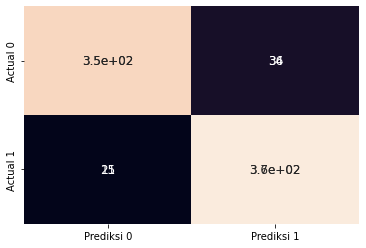

In [ ]:
score = {
    'Akurasi':[],
    'Presisi_mi':[],
    'Recall_mi':[],
    'F1_mi':[],
    'Presisi_ma':[],
    'Recall_ma':[],
    'F1_ma':[]
}
 
start_time = time.time()
list_score_lstm = []
index_fold = 1

for train_index_sentimen, test_index_sentimen in kf.split(np.array(X_resampled), y_resampled):  
  # pembagian data train dan data test
  X_train_sentimen, X_test_sentimen = np.array(X_resampled)[train_index_sentimen], np.array(X_resampled)[test_index_sentimen]
  y_train_tr_sentimen, y_test_ts_sentimen = y_train_tr[train_index_sentimen], y_train_tr[test_index_sentimen]
  
  # train model
  train, hist = LSTMmodel_sentimen(X_train_sentimen,y_train_tr_sentimen,X_test_sentimen,y_test_ts_sentimen, index_fold)
  
  model = load_model('/content/model/'+str(nama_sentimen)+'/Fold'+str(index_fold)+'.h5')
  
  # prediksi
  pred_y = train.predict(X_test_sentimen).argmax(axis=1)
  test_y = y_test_ts_sentimen.argmax(axis=1)

  # print('\n'+'-'*45)
  print('confusion matrix ' + 'Fold ke-' + str(index_fold))
  print('-'*45,'\n')
  cm = confusion_matrix(test_y, pred_y)
  # save confusion matrix
  savetxt('/content/model/'+str(nama_sentimen)+'/cm_Fold_'+str(index_fold)+'.csv', cm, delimiter=',')
  
  acc, prec_mi,prec_ma, recc_mi,recc_ma, f_1_mi,f_1_ma = hitung_score_multiclass(test_y,pred_y)
  # target_names = ['class 0', 'class 1', 'class 2']
  # print(classification_report(test_y, pred_y, target_names=target_names, digits=4))

  score['Akurasi'].append(acc)
  score['Presisi_mi'].append(prec_mi)
  score['Recall_mi'].append(recc_mi)
  score['F1_mi'].append(f_1_mi)
  score['Presisi_ma'].append(prec_ma)
  score['Recall_ma'].append(recc_ma)
  score['F1_ma'].append(f_1_ma)
  from termcolor import colored
  print(colored("Score fold ke-" + str(index_fold), 'red', attrs=['bold']),'\n',
        'acc training  : ' + str(acc) + "%",'\n',
        'Prec Micro  : '+ str(prec_mi)+ "%", '\n',
        'Prec Macro  : '+ str(prec_ma)+ "%",'\n',
        'recc Micro  : '+ str(recc_mi)+ "%", '\n',
        'recc Macro  : '+ str(recc_ma)+ "%", '\n',
        'f_1 Micro  : '+ str(f_1_mi)+ "%",'\n',
        'f_1 Macro  : '+ str(f_1_ma)+ "%",'\n')

  index_fold += 1  

finish_time = time.time()
print('Elapsed time: {}'.format(timedelta(seconds=finish_time-start_time)))

# list_of_floats = [float(item) for item in akurasi_arr_aspek]
print('-'*100,'\n')
print('\n','Rata-rata Score :')
print(' acc training: ' + str(np.mean(score['Akurasi'])) + "%", '\n',
      'Prec Micro: ' + str(np.mean(score['Presisi_mi'])) + "%", '\n',
      'Prec Macro: ' + str(np.mean(score['Presisi_ma'])) + "%", '\n',
      'Recall Micro: ' + str(np.mean(score['Recall_mi'])) + "%", '\n',
      'Recall Macro: ' + str(np.mean(score['Recall_ma'])) + "%", '\n',
      'F1 Micro: ' + str(np.mean(score['F1_mi'])) + "%", '\n',    
      'F1 Macro: ' + str(np.mean(score['F1_ma'])) + "%", '\n',
      )
print("Fold-1 : " +str(score['Akurasi'][0]) + "%", 
      "Fold-2 : " + str(score['Akurasi'][1]) + "%")

## 6.6.Prediksi model

In [ ]:
#Pengujian
indeks=np.where(score["Akurasi"]==np.amax(score['Akurasi']))[0]
model = load_model('/content/model/'+str(nama_sentimen)+'/Fold'+str(indeks[0]+1)+'.h5')

pred_y = model.predict(np.array(X_test)).argmax(axis=1)
test_y = y_test_tr.argmax(axis=1)

target_names = ['Negative(0)', 'Positive(1)']
print(classification_report(test_y, pred_y, target_names=target_names, digits=4))

7/7 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

 Negative(0)     0.7059    0.8571    0.7742        14
 Positive(1)     0.9891    0.9733    0.9811       187

    accuracy                         0.9652       201
   macro avg     0.8475    0.9152    0.8777       201
weighted avg     0.9694    0.9652    0.9667       201

